### IBM AutoAI-SDK Auto-Generated Notebook v1.12.2

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview.
-  pipeline evaluation.
-  pipeline deployment and webservice scoring

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training and holdout data](#train_holdout_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery](#refinery)       
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `watson-machine-learning-client` uninstallation of the old client
 - `watson-machine-learning-client-V4` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed

In [1]:
!pip uninstall watson-machine-learning-client -y

Uninstalling watson-machine-learning-client-1.0.376:
  Successfully uninstalled watson-machine-learning-client-1.0.376


In [2]:
!pip install -U watson-machine-learning-client-V4

     |████████████████████████████████| 1.2MB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 61kB 12.5MB/s eta 0:00:01
     |████████████████████████████████| 768kB 19.5MB/s eta 0:00:01
     |████████████████████████████████| 225kB 20.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5
  Stored in directory: /home/dsxuser/.cache/pip/wheels/75/93/e6/23071b2c037147a0993d34b64a03e51abca84435fc9cd6a278
  Stored in directory: /home/dsxuser/.cache/pip/wheels/23/d9/d7/43fd95b014eed89466154d8373bf4cffbb3d972de7841e213c
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer
  Found existing installation: ibm-cos-sdk-core 2.4.3
    Uninstalling ibm-cos-sdk-core-2.4.3:
      Successfully uninstalled ibm-cos-sdk-core-2.4.3
  Found existing installation: ibm-cos-sdk-s3transfer 2.4.3
    Uninstalling ibm-cos-sdk-s3transfer-2.4.3:
      Successfully uninstalled ibm-cos-sdk-s3transfer-2.4.3
  

In [3]:
!pip install -U autoai-libs

     |████████████████████████████████| 4.3MB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 102kB 14.8MB/s ta 0:00:01
     |████████████████████████████████| 20.1MB 48.6MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 33.9MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Found existing installation: category-encoders 2.0.0
    Uninstalling category-encoders-2.0.0:
      Successfully uninstalled category-encoders-2.0.0
  Found existing installation: autoai-libs 1.10.5
    Uninstalling autoai-libs-1.10.5:
      Successfully uninstalled autoai-libs-1.10.5


<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell contains input parameters provided to run the AutoAI experiment in Watson Studio and COS credentials required to retrieve AutoAI pipeline.

In [4]:
from watson_machine_learning_client.helpers import DataConnection, S3Connection, S3Location

experiment_metadata = dict(
   prediction_type='regression',
   prediction_column='life',
   test_size=0.1,
   scoring='neg_root_mean_squared_error',
   max_number_of_estimators=2,
   training_data_reference = [DataConnection(
        connection=S3Connection(
            api_key='A3ithPg9UJeRnOqsZNC9Y7VihX-yYoE4KSDfTOftN9cw',
            auth_endpoint='https://iam.bluemix.net/oidc/token/',
            endpoint_url='https://s3.eu-geo.objectstorage.softlayer.net'
        ),
            location=S3Location(
            bucket='autoailifeexpectancy-donotdelete-pr-mrvv832wudcqol',
            path='lifeexpect.csv'
        ))
    ],
    training_result_reference = DataConnection(
        connection=S3Connection(
            api_key='A3ithPg9UJeRnOqsZNC9Y7VihX-yYoE4KSDfTOftN9cw',
            auth_endpoint='https://iam.bluemix.net/oidc/token/',
            endpoint_url='https://s3.eu-geo.objectstorage.softlayer.net'
        ),
        location=S3Location(
            bucket='autoailifeexpectancy-donotdelete-pr-mrvv832wudcqol',
            path='auto_ml/b06ae200-bef5-4b6d-81a4-4f50876defac/wml_data/603bb907-cb6b-431d-b9f0-2c7fbb46b04f/data/automl',
            model_location='auto_ml/b06ae200-bef5-4b6d-81a4-4f50876defac/wml_data/603bb907-cb6b-431d-b9f0-2c7fbb46b04f/data/automl/cognito_output/Pipeline5/model.pickle',
            training_status='auto_ml/b06ae200-bef5-4b6d-81a4-4f50876defac/wml_data/603bb907-cb6b-431d-b9f0-2c7fbb46b04f/training-status.json'
        )
    ))

pipeline_name='Pipeline_7'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [5]:
from watson_machine_learning_client.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [6]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [7]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.operators import make_pipeline
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.operators import make_union
from lale.lib.autoai_libs import NumpyPermuteArray
from lale.lib.autoai_libs import TA1
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
import autoai_libs.cognito.transforms.textras_methods
from lale.lib.sklearn import ExtraTreesRegressor

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 5, 9, 11])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['float_int_num', 'float_int_num', 'float_int_num', 'float_int_num'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=100001, missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=100001, filling_values_list=[100001, 100001, 100001, 100001], known_values_list=[[0.0, 1.0], [0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 14.0, 15.0, 16.0, 17.0, 18.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0], [0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 17.0, 23.0, 24.0, 26.0, 31.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0], [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 16.0, 19.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=100001, sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
pipeline_0 = make_pipeline(numpy_column_selector_0, compress_strings, numpy_replace_missing_values_0, numpy_replace_unknown_values, boolean2float(), cat_imputer, cat_encoder, float32_transform())
numpy_column_selector_1 = NumpyColumnSelector(columns=[1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18])
float_str2_float = FloatStr2Float(dtypes_list=['float_int_num', 'float_int_num', 'float_num', 'float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
pipeline_1 = make_pipeline(numpy_column_selector_1, float_str2_float, numpy_replace_missing_values_1, num_imputer, opt_standard_scaler, float32_transform())
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 5, 9, 11, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18])
ta1_0 = TA1(fun=np.sin, name='sin', datatypes=['float'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['status', 'adultmortality', 'infantdeaths', 'alcohol', 'percentageexpenditure', 'hepatitisb', 'measles', 'bmi', 'underfivedeaths', 'polio', 'totalexpenditure', 'dip', 'hiv/aids', 'gdp', 'population', 'thinness119', 'thinness59', 'incomecomp', 'schooling'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 19), additional_col_count_to_keep=15, ptype='regression')
ta1_1 = TA1(fun=autoai_libs.cognito.transforms.textras_methods.sigmoid, name='sigmoid', datatypes=['numeric'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['status', 'adultmortality', 'infantdeaths', 'alcohol', 'percentageexpenditure', 'hepatitisb', 'measles', 'bmi', 'underfivedeaths', 'polio', 'totalexpenditure', 'dip', 'hiv/aids', 'gdp', 'population', 'thinness119', 'thinness59', 'incomecomp', 'schooling', 'sin(infantdeaths)', 'sin(alcohol)', 'sin(percentageexpenditure)', 'sin(measles)', 'sin(bmi)', 'sin(underfivedeaths)', 'sin(polio)', 'sin(totalexpenditure)', 'sin(dip)', 'sin(hiv/aids)', 'sin(population)', 'sin(thinness119)', 'sin(thinness59)', 'sin(incomecomp)', 'sin(schooling)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 19), additional_col_count_to_keep=15, ptype='regression')
extra_trees_regressor = ExtraTreesRegressor(bootstrap=True, n_jobs=4, oob_score=True, random_state=33)
pipeline = make_pipeline(union, numpy_permute_array, ta1_0, fs1_0, ta1_1, fs1_1, extra_trees_regressor)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


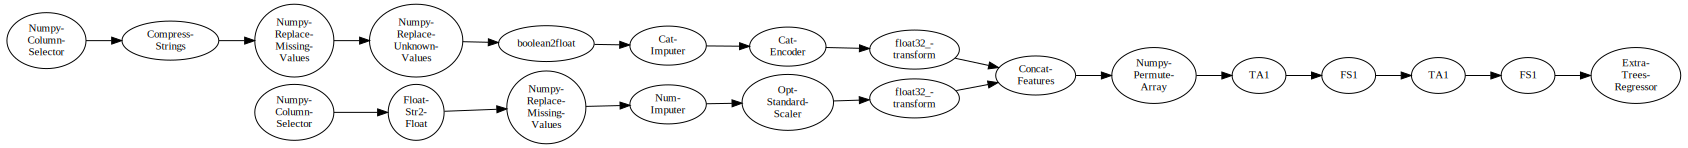

In [8]:
pipeline_model.visualize()

<a id="train_holdout_read"></a>
### Read training and holdout data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [9]:
training_df, holdout_df = optimizer.get_data_connections()[0].read(with_holdout_split=True)

train_X = training_df.drop([experiment_metadata['prediction_column']], axis=1).values
train_y = training_df[experiment_metadata['prediction_column']].values

test_X = holdout_df.drop([experiment_metadata['prediction_column']], axis=1).values
y_true = holdout_df[experiment_metadata['prediction_column']].values

<a id="test_model"></a>
### Test pipeline model locally
**Note**: you can chose the metric to evaluate the model by your own, this example contains only a basic scenario.

In [26]:
from sklearn import metrics
import numpy as np 


predictions = pipeline_model.predict(test_X)
print('MAE:', metrics.mean_absolute_error(y_true, predictions))
print('MSE:', metrics.mean_squared_error(y_true, predictions))
print('r2_score:', r2_score(y_true, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_true, predictions)))

MAE: 0.5063604497585167
MSE: 0.6969533173036409
r2_score: 0.9934985472923176
RMSE: 0.8348372998995918


<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

In [11]:
# @hidden cell
wml_credentials = {
  "apikey": "goh8USQL6eOqtUf5v6gRdQlZdi0c7xeco3mwSuUTDml_",
  "iam_apikey_description": "Auto-generated for key f47f2e71-9202-427d-a5e0-f1218cbd8510",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/be7b73d38fca445daf14fb6ae2b0f614::serviceid:ServiceId-5e88a2b4-4c64-4bfb-9618-51d7aaf24514",
  "instance_id": "e295d7a4-e2c6-4261-bd28-dbe0596e21c4",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

<a id="deployment"></a>
### Create deployment

**Action**: If you want to deploy refined pipeline please change the `pipeline_model` to `new_pipeline`.
 
If you prefer you can also change the `deployment_name`.

In [ ]:
from watson_machine_learning_client.deployment import WebService

service = WebService(wml_credentials)

service.create(
    model=pipeline_model,
    metadata=experiment_metadata,
    deployment_name=f'{pipeline_name}_webservice'
)

Deployment object could be printed to show basic information:

In [ ]:
print(service)

To be able to show all available information about deployment use `.get_params()` method:

In [ ]:
service.get_params()

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [15]:
predictions = service.score(payload=holdout_df.drop([experiment_metadata['prediction_column']], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction'],
   'values': [[70.39000244140625],
    [67.16999740600586],
    [66.4000015258789],
    [75.6099983215332],
    [63.790000915527344],
    [56.97999954223633],
    [70.68000030517578],
    [54.04000053405762],
    [74.86999969482422],
    [72.10999755859375]]}]}

In [17]:
print(service.scoring_url)

https://eu-gb.ml.cloud.ibm.com/v4/deployments/c8e101fa-4ede-49aa-b1cd-5cee3a93cd95/predictions


<a id="authors"></a>
### Authors

Licensed Materials - Copyright © 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___